Load data

In [113]:
# Path: SL_NN.ipynb
import numpy as np
import matplotlib.pyplot as plt


X = np.load('archive-2/Sign-language-digits-dataset/X.npy')
X = X.reshape(X.shape[0], -1)
Y = np.load('archive-2/Sign-language-digits-dataset/Y.npy')
x_9 = X[:204]

x_0 = X[204:409]

x_7 = X[409:615]

x_6 = X[615:822]

x_1 = X[822:1028]

x_8 = X[1028:1236]

x_4 = X[1236:1443]

x_3 = X[1443:1649]

x_2 = X[1649:1855]

x_5 = X[1855:]

X = np.concatenate((x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9))
Y = np.argmax(Y, axis=1).reshape(-1, 1)

from sklearn.decomposition import PCA

pca = PCA(n_components=2025)
X = pca.fit_transform(X)

from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
# X and y should be NumPy arrays or Pandas DataFrames
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


print(X_train.shape)
print(Y.shape)

(1649, 2025)
(2062, 1)


In [69]:
# Add sigmoid FUNCTION from the previous lab
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

Plotting visualization data

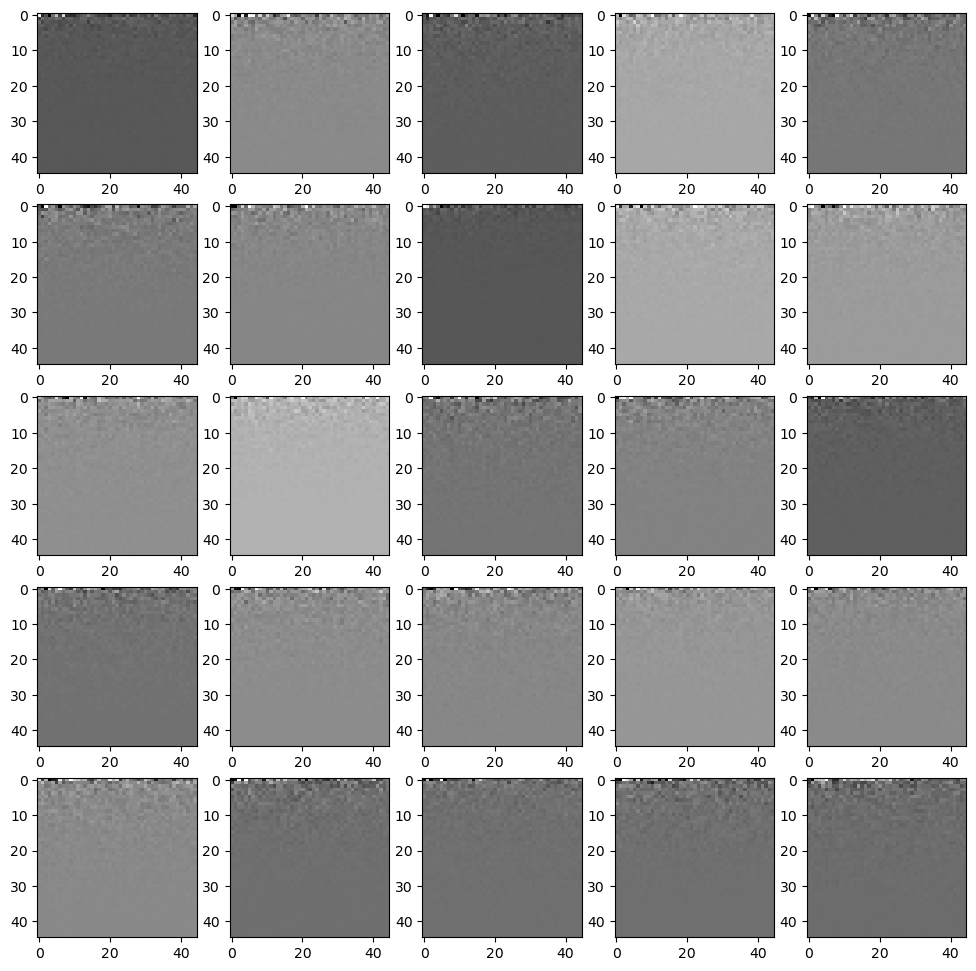

In [114]:
fig, axis = plt.subplots(5,5,figsize=(12,12))
for i in range(5):
    for j in range(5):                                      
        axis[i,j].imshow(X_train[np.random.randint(0,len(X_train))  ,:].reshape(45,45), cmap="gray") 


### Normalizing the data (Z-Score Normalization)

In [45]:
def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    normalized_data = (X - mean) / std
    return normalized_data, mean, std

### Run feature normalization

In [115]:
X_train, X_mean, X_std = normalize(X_train)

In [47]:
print(X.shape)

(2062, 1024)


**NN cost function:** 
$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^k [-y_k^{(i)} log(h_\theta(x^{(i)})_k) - ( 1 -y_k^{(i)} log (1-h_\theta(x^{(i)})_k)] + \frac{\lambda}{2m}[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j,k}^{(1)})^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j,k}^{(2)})^2]$

*nnCostFunction* computes the NN cost (above) and the gradients with and without regularization.

In [54]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [49]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigGrad= sigmoid(z)
    
    return sigGrad

### Random initialization

Select values for $\theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

In [50]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [116]:
input_layer_size  = 2025
hidden_layer_size = 15
num_labels = 10

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())
print(initial_Theta2.shape)

(10, 16)


### Gradient Descent for shallow NN (input-layer => ONE hidden layer => output layer) 

In [108]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2, regJ, regGrad1, redGrad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [117]:
#It may take very long to finish the training. 
#For 1000 iterations the Training Set Accuracy: 95.28(lambda=0.1; alpha=1)
#You may need more iterations (e.g. 1500) to get better accuracy


alpha=0.1 #learning rate
num_iters=2000
Lambda=0.1
num_labels = 10

nnTheta, nnJ_history = gradientDescentnn(X_train,y_train,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

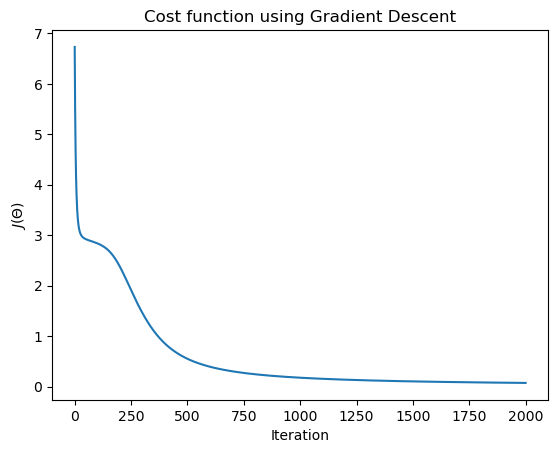

In [118]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [19]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
        #number of training examples
    m= len(X)
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m, 1)), X, axis = 1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1=sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T) #Inputs to the output layer neurons
    a2=sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [119]:
#Call function predict

pred3 = predict(Theta1, Theta2, X_train).reshape(-1, 1)

test_pred = predict(Theta1, Theta2, X_test).reshape(-1, 1)

print("Training Set Accuracy: ", sum(pred3==y_train)[0]/1649*100,"%")
print("Testing Set Accuracy: ", sum(test_pred==y_test)[0]/413*100,"%")

Training Set Accuracy:  90.05457853244391 %
Testing Set Accuracy:  34.14043583535109 %


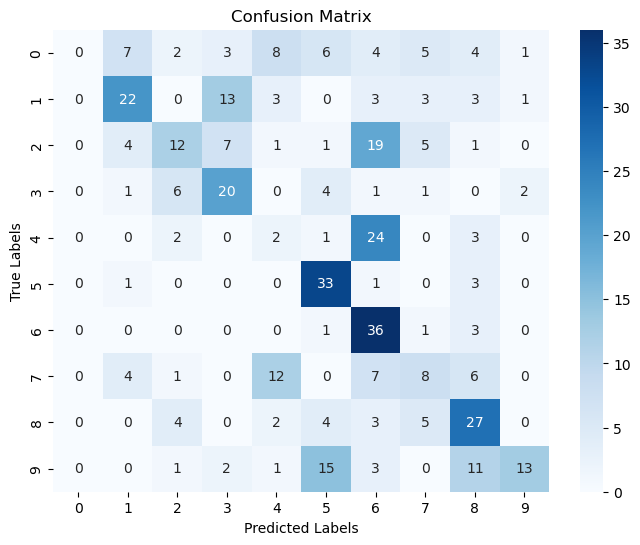

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, test_pred)
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()